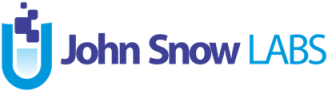

**nlptest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, or Spacy** models, it has got you covered. You can test any Named Entity Recognition (NER) and Text Classification model using the libraray. The library supports 50+ out of the box tests. These tests fall into robustness, accuracy, bias, representation and fairness test categories.

Metrics are calculated by comparing the model's extractions in the original list of sentences against the extractions carried out in the noisy list of sentences. The original annotated labels are not used at any point, we are simply comparing the model against itself in a 2 settings.

# Getting started with nlptest on spacy

In [ ]:
!pip install nlptest

In [ ]:
!pip install nlptest==1.0.0rc1

#Harness and its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a given NLP model on a given task using test data and generates a report with test results.Harness can be imported from the nlptest library in the following way.

In [2]:
#Import Harness from the nlptest library
from nlptest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.
<br/>

## Robustness Testing

In this example, we will be testing a model's robustness. We will be applying 2 tests: uppercase and add_typo. The real-world project workflow of the model robustness testing and fixing in this case goes as follows:

1. Train NER model on original CoNLL training set

2. Test NER model robustness on CoNLL test set

3. Augment CoNLL training set based on test results 

4. Train new NER model on augmented CoNLL training set

5. Test new NER model robustness on the CoNLL test set from step 2

6. Compare robustness of new NER model against original NER model

####Load Train and Test CoNLL

In [ ]:
# Load test CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/nlptest/release/1.0.0/nlptest/data/conll/sample.conll

# Load train CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/nlptest/release/1.0.0/demo/data/conll03.conll

####Convert CoNLL into spaCy's JSON format:

In [4]:
import json
import spacy
from pathlib import Path

def read_conll_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read().strip()

    sentences = content.split("\n\n")

    data = []
    for sentence in sentences:
        tokens = sentence.split("\n")
        token_data = []

        for token in tokens:
            parts = token.split()
            if len(parts) == 4:
                token_data.append((parts[0], parts[3]))

        data.append(token_data)

    return data

def convert_to_spacy_format(data):
    spacy_data = []

    for tokens in data:
        text = " ".join([token[0] for token in tokens])
        entities = []

        i = 0
        while i < len(tokens):
            token, label = tokens[i]

            if label.startswith("B-"):
                start = i
                end = i
                label = label[2:]

                i += 1
                while i < len(tokens) and tokens[i][1] == f"I-{label}":
                    end = i
                    i += 1

                start_char = len(" ".join([token[0] for token in tokens[:start]])) + (1 if start > 0 else 0)
                end_char = len(" ".join([token[0] for token in tokens[:end+1]]))

                entities.append((start_char, end_char, label))
            else:
                i += 1

        spacy_data.append({"text": text, "entities": entities})

    return spacy_data

def convert_conll_to_spacy(conll_file_path, output_file_path):
    conll_data = read_conll_file(conll_file_path)
    spacy_data = convert_to_spacy_format(conll_data)

    with open(output_file_path, "w", encoding="utf-8") as file:
        json.dump(spacy_data, file, indent=2, ensure_ascii=False)



/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


####Provide path to train CoNLL and output path to save spaCy's JSON format

In [5]:
conll_file_path = "/content/conll03.conll"
output_file_path = "output_spacy.json"
convert_conll_to_spacy(conll_file_path, output_file_path)

####Training Pipeline

In [7]:
import spacy
import random
import json
import os
from spacy.training import Example
from spacy.util import minibatch, compounding
from pathlib import Path

def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return [(item["text"], {"entities": item["entities"]}) for item in data]

def train_ner_model(training_data, output_dir, n_iter=15):
    nlp = spacy.blank("en")
    nlp.add_pipe("ner")
    ner = nlp.get_pipe("ner")

    for _, annotations in training_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

    # Set the random seeds manually
    random.seed(1)
    os.environ["PYTHONHASHSEED"] = str(1)
    
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(training_data)
            losses = {}
            batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))

            for batch in batches:
                examples = []
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    examples.append(example)
                nlp.update(examples, sgd=optimizer, drop=0.35, losses=losses)

            print(f"Losses at iteration {itn}: {losses}")

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print(f"Saved model to {output_dir}")

def load_model(model_dir):
    model_path = Path(model_dir)
    nlp = spacy.load(model_path)
    return nlp

####Provide path to obtained spaCy's JSON format and path to save the trained model.

In [8]:
data_file = "output_spacy.json"
output_dir = "output_model"
train_data = load_data(data_file)
train_ner_model(train_data, output_dir)


Losses at iteration 0: {'ner': 6331.1387559876775}
Losses at iteration 1: {'ner': 3874.196825030379}
Losses at iteration 2: {'ner': 2960.227781806303}
Losses at iteration 3: {'ner': 2400.0586164952597}
Losses at iteration 4: {'ner': 2170.3479700193698}
Losses at iteration 5: {'ner': 1881.1471386019464}
Losses at iteration 6: {'ner': 1646.7935458840607}
Losses at iteration 7: {'ner': 1418.8968730459426}
Losses at iteration 8: {'ner': 1298.9070137468875}
Losses at iteration 9: {'ner': 1228.9143317361247}
Losses at iteration 10: {'ner': 1066.6531094868753}
Losses at iteration 11: {'ner': 988.2575125424044}
Losses at iteration 12: {'ner': 873.3168822050162}
Losses at iteration 13: {'ner': 847.699817928458}
Losses at iteration 14: {'ner': 825.5044507861519}
Saved model to output_model


#### Load trained model

In [9]:
model_dir = "output_model"
spacy_model = load_model(model_dir)


####Test NER Model Robustness 

In [10]:
h = Harness(task="ner",model=spacy_model, data="/content/sample.conll")

In [11]:
h.configure(
{'defaults': {'min_pass_rate': 0.60},
 'tests': {'robustness': {'add_typo': {'min_pass_rate': 0.60}, 
                          'uppercase':{'min_pass_rate': 0.60},
                         }
          }
 }
 )

{'defaults': {'min_pass_rate': 0.6},
 'tests': {'robustness': {'add_typo': {'min_pass_rate': 0.6},
   'uppercase': {'min_pass_rate': 0.6}}}}

Here we have configured the harness to perform two robustness tests (add_typo and uppercase) and defined the minimum pass rate for each test.


#### Generating the test cases.

In [12]:
h.generate()

Generating testcases... (robustness): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


harness.generate() method automatically generates the test cases (based on the provided configuration)

In [13]:
h.testcases()

,category,test_type,original,test_case,expected_result
0,robustness,add_typo,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","SOCCER - JAPAN GET LUCKY WIN , CHINA IY SURPRI...","[LOC, LOC, LOC]"
1,robustness,add_typo,Nadim Ladki,Nadim aLdki,[PER]
2,robustness,add_typo,"AL-AIN , United Arab Emirates 1996-12-06","AL-AIN , United Arag Emirates 1996-12-06","[LOC, ORG]"
3,robustness,add_typo,Japan began the defence of their Asian Cup tit...,Japan began the defence of their Asian Cup tit...,"[LOC, MISC, LOC, MISC]"
4,robustness,add_typo,But China saw their luck desert them in the se...,But China saw their luck desert them in the se...,"[LOC, LOC]"
...,...,...,...,...,...
447,robustness,uppercase,Portuguesa 1 Atletico Mineiro 0,PORTUGUESA 1 ATLETICO MINEIRO 0,"[ORG, ORG]"
448,robustness,uppercase,CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .,CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .,[PER]
449,robustness,uppercase,Robert Galvin,ROBERT GALVIN,[PER]
450,robustness,uppercase,MELBOURNE 1996-12-06,MELBOURNE 1996-12-06,[LOC]


harness.testcases() method gives the produced test cases in form of a pandas data frame.

####Saving test configurations, data, test cases

In [14]:
h.save("saved_test_configurations")

####Running the tests

In [15]:
h.run()

Running test cases...: 100%|██████████| 452/452 [00:03<00:00, 140.96it/s]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

In [16]:
h.generated_results()

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,add_typo,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","SOCCER - JAPAN GET LUCKY WIN , CHINA IY SURPRI...","[LOC, LOC, LOC]","[LOC, ORG]",False
1,robustness,add_typo,Nadim Ladki,Nadim aLdki,[PER],[],False
2,robustness,add_typo,"AL-AIN , United Arab Emirates 1996-12-06","AL-AIN , United Arag Emirates 1996-12-06","[LOC, ORG]","[LOC, ORG]",True
3,robustness,add_typo,Japan began the defence of their Asian Cup tit...,Japan began the defence of their Asian Cup tit...,"[LOC, MISC, LOC, MISC]","[LOC, MISC, LOC, MISC]",True
4,robustness,add_typo,But China saw their luck desert them in the se...,But China saw their luck desert them in the se...,"[LOC, LOC]","[LOC, LOC]",True
...,...,...,...,...,...,...,...
447,robustness,uppercase,Portuguesa 1 Atletico Mineiro 0,PORTUGUESA 1 ATLETICO MINEIRO 0,"[ORG, ORG]","[ORG, ORG]",True
448,robustness,uppercase,CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .,CRICKET - LARA ENDURES ANOTHER MISERABLE DAY .,[PER],[PER],True
449,robustness,uppercase,Robert Galvin,ROBERT GALVIN,[PER],[MISC],False
450,robustness,uppercase,MELBOURNE 1996-12-06,MELBOURNE 1996-12-06,[LOC],[LOC],True


This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

#### Report of the tests

In [17]:
h.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_typo,65,161,71%,60%,True
1,robustness,uppercase,147,79,35%,60%,False


It summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

####Augment CoNLL Training Set Based on Robustness Test Results

In [18]:
h.augment("conll03.conll", "augmented.conll", inplace=False)

Generating testcases... (robustness): 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]


#### Provide path to Augmented CoNLL and output path to save spaCy's JSON format for augmented conll.

In [19]:
conll_file_path = "augmented.conll"
output_file_path = "augmented_output_spacy.json"
convert_conll_to_spacy(conll_file_path, output_file_path)

####Provide path to augmented spaCy's JSON format and path to save new augmented model.

In [20]:
data_file = "augmented_output_spacy.json"
output_dir = "augmented_output_model"
train_data = load_data(data_file)
train_ner_model(train_data, output_dir)

Losses at iteration 0: {'ner': 9960.020726028022}
Losses at iteration 1: {'ner': 6103.436792660515}
Losses at iteration 2: {'ner': 4584.702283575691}
Losses at iteration 3: {'ner': 3879.986068341565}
Losses at iteration 4: {'ner': 3160.994105005162}
Losses at iteration 5: {'ner': 2843.710486990537}
Losses at iteration 6: {'ner': 2636.114377719258}
Losses at iteration 7: {'ner': 2371.578565633728}
Losses at iteration 8: {'ner': 2045.3679234240415}
Losses at iteration 9: {'ner': 1885.1295120296638}
Losses at iteration 10: {'ner': 1836.4432725607473}
Losses at iteration 11: {'ner': 1661.385629940751}
Losses at iteration 12: {'ner': 1577.9893278237018}
Losses at iteration 13: {'ner': 1488.2155695169724}
Losses at iteration 14: {'ner': 1375.0141242825746}
Saved model to augmented_output_model


####Load trained augmented model

In [21]:
model_dir = "augmented_output_model"
augmented_spacy_model = load_model(model_dir)

#### Load saved test configurations, data

In [22]:
harness = Harness.load("saved_test_configurations",model=augmented_spacy_model)

Generating testcases... (robustness): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


####Test New NER Model Robustness

In [23]:
harness.run().report()

Running test cases...: 100%|██████████| 452/452 [00:03<00:00, 137.60it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_typo,39,187,83%,60%,True
1,robustness,uppercase,90,136,60%,60%,True



We can see that after performing augmentation, even the **uppercase** test is passing which failed earlier.